<a href="https://colab.research.google.com/github/trollmannen/Data-Science/blob/main/Twitch-Chat-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [289]:
CLIENT_ID = ''
CLIENT_SECRET = ''

In [ ]:
#!pip install -e git+https://github.com/sotif/Twitch-Python.git@master#egg=Twitch-Python

In [ ]:
import twitch
helix = twitch.Helix(CLIENT_ID, CLIENT_SECRET)

## Part 1: Gather & Store Data

In [ ]:
from tqdm import tqdm
def get_chats(vod_ids):
  chats = []
  meta = {}

  for video, comments in helix.videos(vod_ids).comments:
    meta[int(video.id)] = video.data
    for comment in tqdm(comments):
      chats.append((comment.created_at,
                    comment.commenter.display_name,
                    comment.message.body,
                    comment.content_offset_seconds,
                    video.id))

  chats = pd.DataFrame(columns=['timestamp',
                                'username',
                                'message',
                                'seconds',
                                'vod_id'],
                       data=chats)
  return chats,meta

In [ ]:
def get_latest_chats(streamers,n):
  chats = []
  meta = {}

  for user, videos in helix.users(streamers).videos(first=n):
    for video, comments in videos.comments:
      meta[int(video.id)] = video.data
      for comment in tqdm(comments):
        chats.append((comment.created_at,
                      comment.commenter.display_name,
                      comment.message.body,
                      comment.content_offset_seconds,
                      video.id))

  chats = pd.DataFrame(columns=['timestamp',
                                'username',
                                'message',
                                'seconds',
                                'vod_id'],
                       data=chats)
  return chats,meta

In [ ]:
chats,meta = get_chats([1454475889])
#chats,meta = get_latest_chats(['sodapoppin','forsen'],1)

688652it [39:36, 289.75it/s]


In [ ]:
chats.to_csv('chats.csv',index=False)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!cp -r 'chats.csv' /content/drive/MyDrive/twitch/

## Part 2: Clean & Organize Data

In [265]:
chats = pd.read_csv('chats.csv')
#chats = pd.read_csv('/content/drive/MyDrive/twitch/chats.csv', index_col='timestamp', parse_dates=True)

In [266]:
chats['delta'] = pd.to_timedelta(chats['seconds'],unit="s")

In [267]:
chats.index = chats['delta']

In [268]:
chats = chats.drop(['timestamp','delta'],axis=1)

## Part 3: EDA

### What does the dataset look like?

In [269]:
chats

,username,message,seconds,vod_id
delta,,,,
0 days 00:00:00.484000,JamileAAU,NaM Clap FUCK WEEBS,0.484,1454475889
0 days 00:00:00.634000,longnoselongdic,WHERE ARE YOUUU,0.634,1454475889
0 days 00:00:00.666000,w33dsack,AUUUUUUGH HUH,0.666,1454475889
0 days 00:00:00.678000,reptify,xqcDespair,0.678,1454475889
0 days 00:00:00.745000,m_orph,HOLY SHIT LIVE PogU,0.745,1454475889
...,...,...,...,...
0 days 20:43:09.123000,itzShoTime,AUGHHHHHHHHHHHHHHHHHHHHH,74589.123,1454475889
0 days 20:43:09.143000,FreeformFob,Cringe xqcow,74589.143,1454475889
0 days 20:43:09.153000,Netcat,!moduleson,74589.153,1454475889


In [270]:
vod_id = chats.iloc[0]['vod_id']

### Who's the streamer?

In [271]:
meta[vod_id]['user_name']

'xQcOW'

### What is the stream title?

In [272]:
meta[vod_id]['title']

'🔰CLICK THIS NOW🔰BIG NEWS🔰INSANE DRAMA🔰ENDLESS GARBAGE FOR 1000 HOURS🔰HOMEWORKS ARE DONE🔰WE CAN STREAM🔰BAD VIDEOS AND TERRIBLE GAMES🔰'

### How many unique viewers have watched parts of this stream?

In [273]:
meta[vod_id]['view_count']

3536795

### How long did the stream last?

In [274]:
meta[vod_id]['duration']

'20h42m59s'

### How many chat messages were banned?

In [275]:
len(chats[chats['message'].isnull()])

4

In [276]:
chats = chats.dropna()

### How many funny moments were there?

In [277]:
laughing = chats.loc[chats['message'].str.contains("LUL|KEK", case=False)].resample(rule='min').count()

[Text(0, 0.5, 'Laughing Emotes'), Text(0.5, 0, '')]

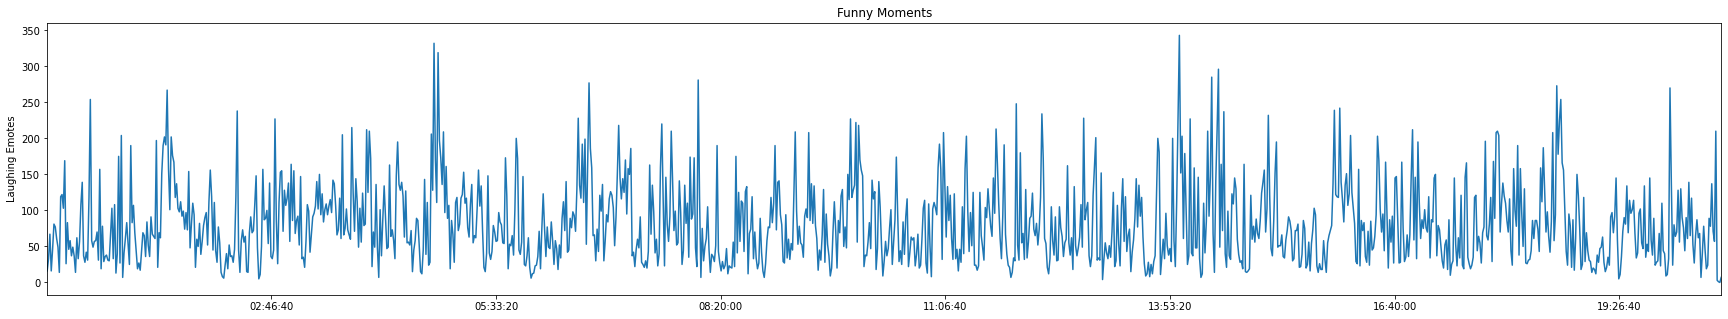

In [288]:
from matplotlib import dates
title='Funny Moments'
ylabel='Laughing Emotes'
xlabel=''

ax = laughing['message'].plot(figsize=(30,5),title=title)#,x_compat=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#ax.xaxis.set_major_locator(dates.HourLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

In [280]:
funny_moments = laughing[laughing['message'] > 300]['message']

In [282]:
len(funny_moments)

3

### When did the funny moments occur?

In [283]:
funny_moments.sort_values(ascending=False)

delta
0 days 14:00:16.166000    343
0 days 04:47:16.166000    332
0 days 04:50:16.166000    319
Name: message, dtype: int64

## Extras

In [284]:
helix.video(1456101444).data

{'created_at': '2022-04-14T22:10:11Z',
 'description': '',
 'duration': '9h1m27s',
 'id': '1456101444',
 'language': 'en',
 'muted_segments': None,
 'published_at': '2022-04-14T22:10:11Z',
 'stream_id': '46171442765',
 'thumbnail_url': '',
 'title': '🔴CLICK FAST🔴BIG JUICER🔴#1 WORLD AT ALL🔴DRAMA ONLY🔴BIG NEWS🔴CRAZY CONTENT🔴OMG🔴DONT MISS IT🔴9845U4895738978593🔴9878935789578🔴487🔴',
 'type': 'archive',
 'url': 'https://www.twitch.tv/videos/1456101444',
 'user_id': '71092938',
 'user_login': 'xqcow',
 'user_name': 'xQcOW',
 'view_count': 17233,
 'viewable': 'public'}

In [285]:
helix.user('xqcow').data

{'broadcaster_type': 'partner',
 'created_at': '2014-09-12T23:50:05Z',
 'description': 'THE BEST AT ABSOLUTELY EVERYTHING. THE JUICER. LEADER OF THE JUICERS.',
 'display_name': 'xQcOW',
 'id': '71092938',
 'login': 'xqcow',
 'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/dc330b28-9c9f-4df4-b8b6-ff56b3c094fd-channel_offline_image-1920x1080.png',
 'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/xqcow-profile_image-9298dca608632101-300x300.jpeg',
 'type': '',
 'view_count': 522606655}

In [286]:
helix.user('xqcow').is_live

True